# Characterizing specific genes

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
from typing import Collection, Sequence

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.text import Text
from sklearn.manifold import TSNE

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.analysis.sublineage_model_analysis import (
    load_sublineage_model_posteriors,
    sublineage_to_lineage_map,
)
from speclet.io import project_root, temp_dir
from speclet.managers.posterior_data_manager import PosteriorDataManager as PostDataMan
from speclet.managers.posterior_data_manager import PosteriorDataManagers as PostDataMen
from speclet.plot import set_speclet_theme
from speclet.plot.color_pal import (
    lineage_color_pal,
    pal_to_legend_handles,
    sublineage_color_pal,
)
from speclet.project_configuration import arviz_config, get_model_configuration_file
from speclet.string_functions import str_hash

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 709
np.random.seed(RANDOM_SEED)
arviz_config()

# File paths
config_path = project_root() / get_model_configuration_file()

### Data

#### Model posteriors

In [5]:
postmen = load_sublineage_model_posteriors()

In [6]:
postmen.keys

['bile duct (cholangiocarcinoma)',
 'bile duct (gallbladder adenocarcinoma)',
 'blood (ALL)',
 'blood (AML)',
 'blood (CLL)',
 'blood (CML)',
 'bone (Ewing sarcoma)',
 'bone (chordoma)',
 'bone (osteosarcoma)',
 'breast',
 'central nervous system (glioma)',
 'central nervous system (medulloblastoma)',
 'cervix (cervical carcinoma)',
 'cervix (cervical squamous)',
 'colorectal',
 'esophagus (esophagus adenocarcinoma)',
 'esophagus (esophagus squamous)',
 'eye (uveal melanoma)',
 'gastric (gastric adenocarcinoma)',
 'kidney (renal cell carcinoma)',
 'liver (hepatocellular carcinoma)',
 'lung (NSCLC)',
 'lung (SCLC)',
 'lung (mesothelioma)',
 'lymphocyte (hodgkin lymphoma)',
 'lymphocyte (lymphoma unspecified)',
 'lymphocyte (non hodgkin lymphoma)',
 'ovary (ovary adenocarcinoma)',
 'pancreas',
 'peripheral nervous system (neuroblastoma)',
 'plasma cell (multiple myeloma)',
 'prostate',
 'skin (melanoma)',
 'skin (skin squamous)',
 'soft tissue (ATRT)',
 'soft tissue (liposarcoma)',
 'sof

In [7]:
len(postmen)

43

In [8]:
sub_to_lineage, lineages = sublineage_to_lineage_map(postmen)

In [9]:
sublineage_pal = sublineage_color_pal()
lineage_pal = lineage_color_pal()

## Analysis

### Gather data for key genes

In [10]:
STASH_DIR = temp_dir() / "100_110_specific-gene-characterization-stash"
if not STASH_DIR.exists():
    STASH_DIR.mkdir()

In [11]:
def get_parameters_for_gene(
    pm: PostDataMan, gene: str, stash: bool = True
) -> pd.DataFrame:
    pattern = rf"\[{gene}\]"
    stash_fp = STASH_DIR / f"post-summary-df_{pm.id}-{gene}"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    post = (
        pm.posterior_summary.copy()
        .filter_string("parameter", pattern)
        .reset_index(drop=True)
        .assign(lineage_subtype=pm.id, hugo_symbol=gene)
    )
    assert len(post) > 0, f"No results for gene '{gene}' found in {pm.id}."
    post.to_csv(stash_fp, index=False)
    return post

In [12]:
def get_parameters_for_genes(
    pms: PostDataMen, genes: Sequence[str], stash: bool = True
) -> pd.DataFrame:
    parameters = pd.DataFrame()
    for gene in genes:
        df = pd.concat(
            [
                get_parameters_for_gene(pm, gene, stash=stash)
                for pm in pms.as_dict().values()
            ]
        )
        parameters = pd.concat([parameters, df])

    parameters = (
        parameters.assign(lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage))
        .filter_column_isin("var_name", ["sigma_h"], complement=True)
        .reset_index(drop=True)
    )
    parameters["var_name"] = pd.Categorical(
        parameters["var_name"],
        categories=parameters["var_name"].unique(),
        ordered=True,
    )
    return parameters

In [13]:
RAS_GENES = ["HRAS", "KRAS", "NRAS"]
RAF_GENES = ["ARAF", "BRAF", "RAF1"]
TSGS = sorted(["TP53", "RB1", "PTEN", "FBXW7", "APC"])
FANC_GENES = sorted(list(set(["FANCA", "FANCC", "FANCD2", "FANCE", "FANCF", "FANCG"])))

ras_params = get_parameters_for_genes(postmen, RAS_GENES)
raf_params = get_parameters_for_genes(postmen, RAF_GENES)
tsg_params = get_parameters_for_genes(postmen, TSGS)
fanc_params = get_parameters_for_genes(postmen, FANC_GENES)

In [14]:
def extract_sublineage(s: str) -> str:
    if "(" not in s:
        return s
    return s.split("(")[1].replace(")", "")


def axis_labels_to_sublineage(lbl: Text) -> Text:
    lbl.set_text(extract_sublineage(lbl.get_text()))
    return lbl


def axis_labels_parameters(lbl: Text) -> Text:
    t = lbl.get_text()
    t = t.replace("mu_", r"\mu_")
    t = f"${t}$"
    lbl.set_text(t)
    return lbl

In [15]:
def gene_set_characterization_heatmap(
    genes: Sequence[str],
    params_df: pd.DataFrame,
    vmin: float | None = None,
    vmax: float | None = None,
) -> None:
    fig, axes = plt.subplots(
        len(genes), figsize=(8, 1.5 * len(genes)), sharex=True, sharey=True
    )

    # CLustermap just to get clustering of lineage subtypes.
    X = params_df.pivot_wider(
        "parameter", names_from="lineage_subtype", values_from="mean"
    ).set_index("parameter")
    cg = sns.clustermap(data=X, xticklabels=1)
    sublineage_order = [x.get_text() for x in cg.ax_heatmap.get_xticklabels()]
    cg.figure.clear()

    for ax, (gene, df_g) in zip(axes, params_df.groupby("hugo_symbol")):
        X = df_g.pivot_wider(
            "var_name", names_from="lineage_subtype", values_from="mean"
        ).set_index("var_name")[sublineage_order]
        sns.heatmap(
            data=X,
            xticklabels=1,
            yticklabels=1,
            cmap="seismic",
            center=0,
            vmin=vmin,
            vmax=vmax,
            ax=ax,
        )
        xlbls = [axis_labels_to_sublineage(lbl) for lbl in ax.get_xticklabels()]
        ax.set_xticklabels(xlbls, rotation=45, ha="right", size=8)
        ylbls = [axis_labels_parameters(v) for v in ax.get_yticklabels()]
        ax.set_yticklabels(labels=ylbls, rotation=0)
        ax.set_ylabel(f"${gene}$")

    fig.tight_layout()
    plt.show()

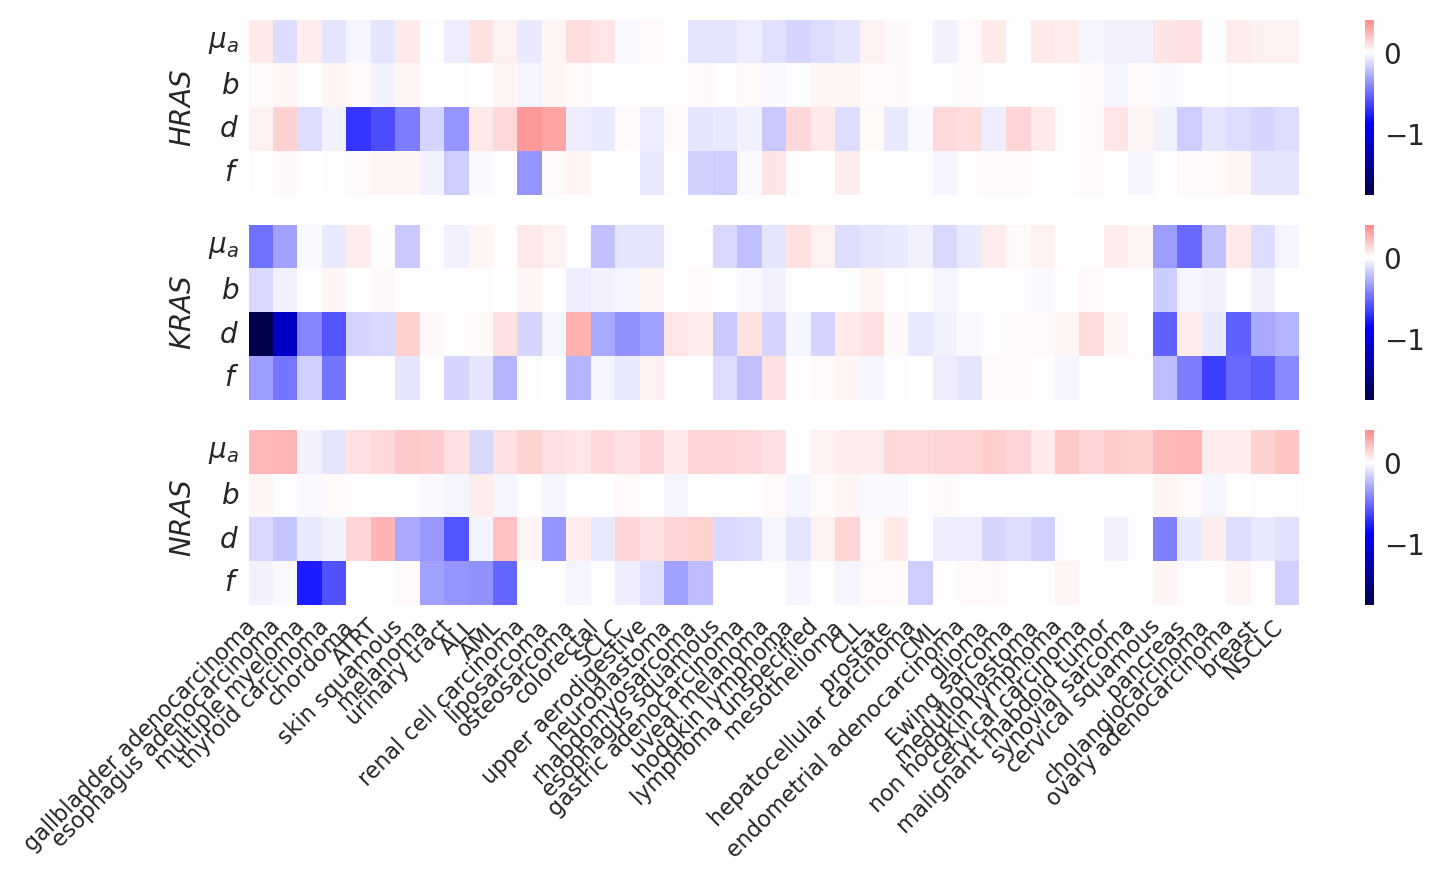

<Figure size 1000x1000 with 0 Axes>

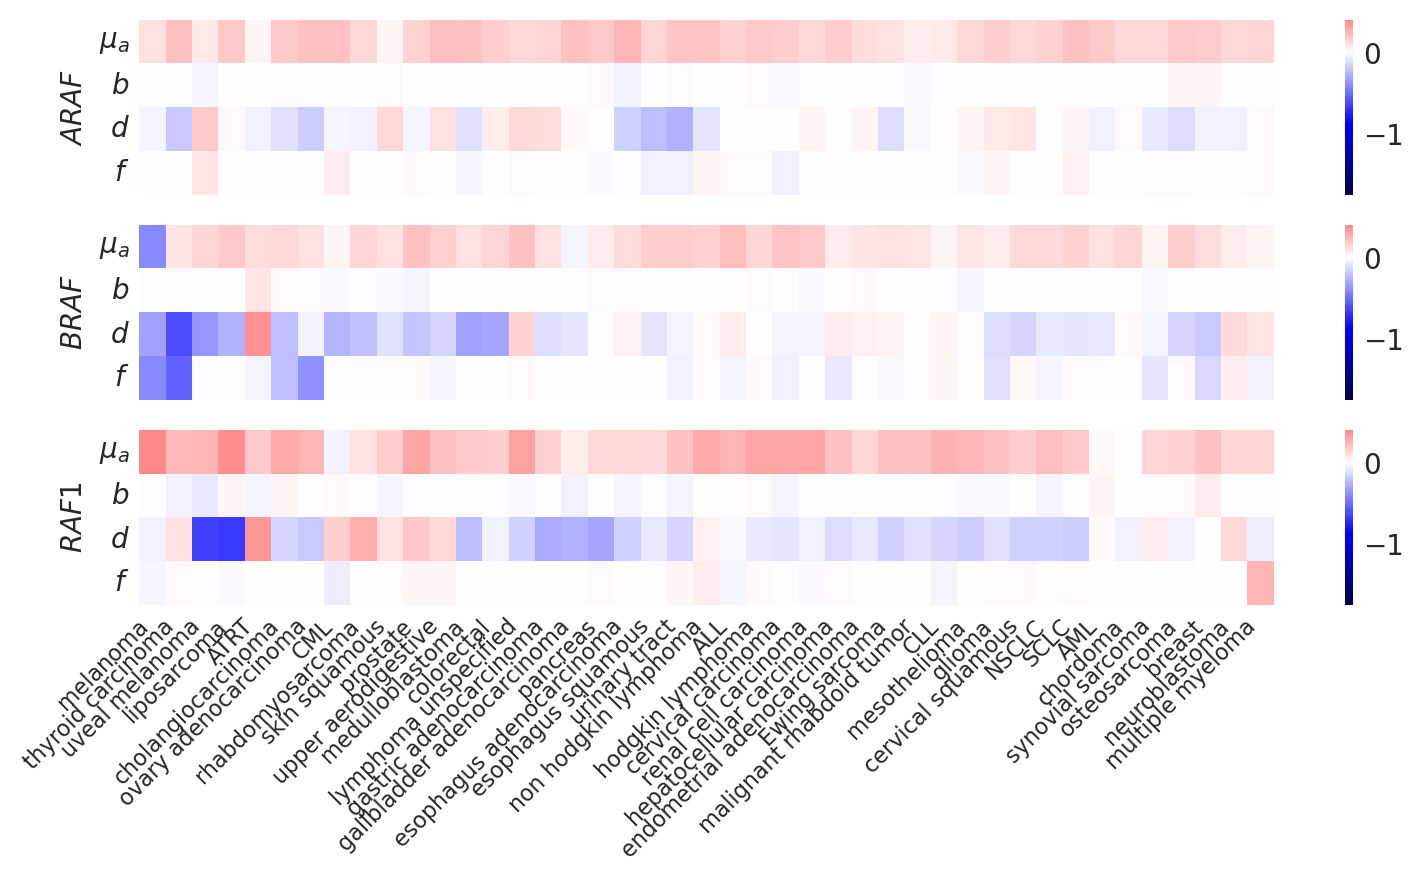

<Figure size 1000x1000 with 0 Axes>

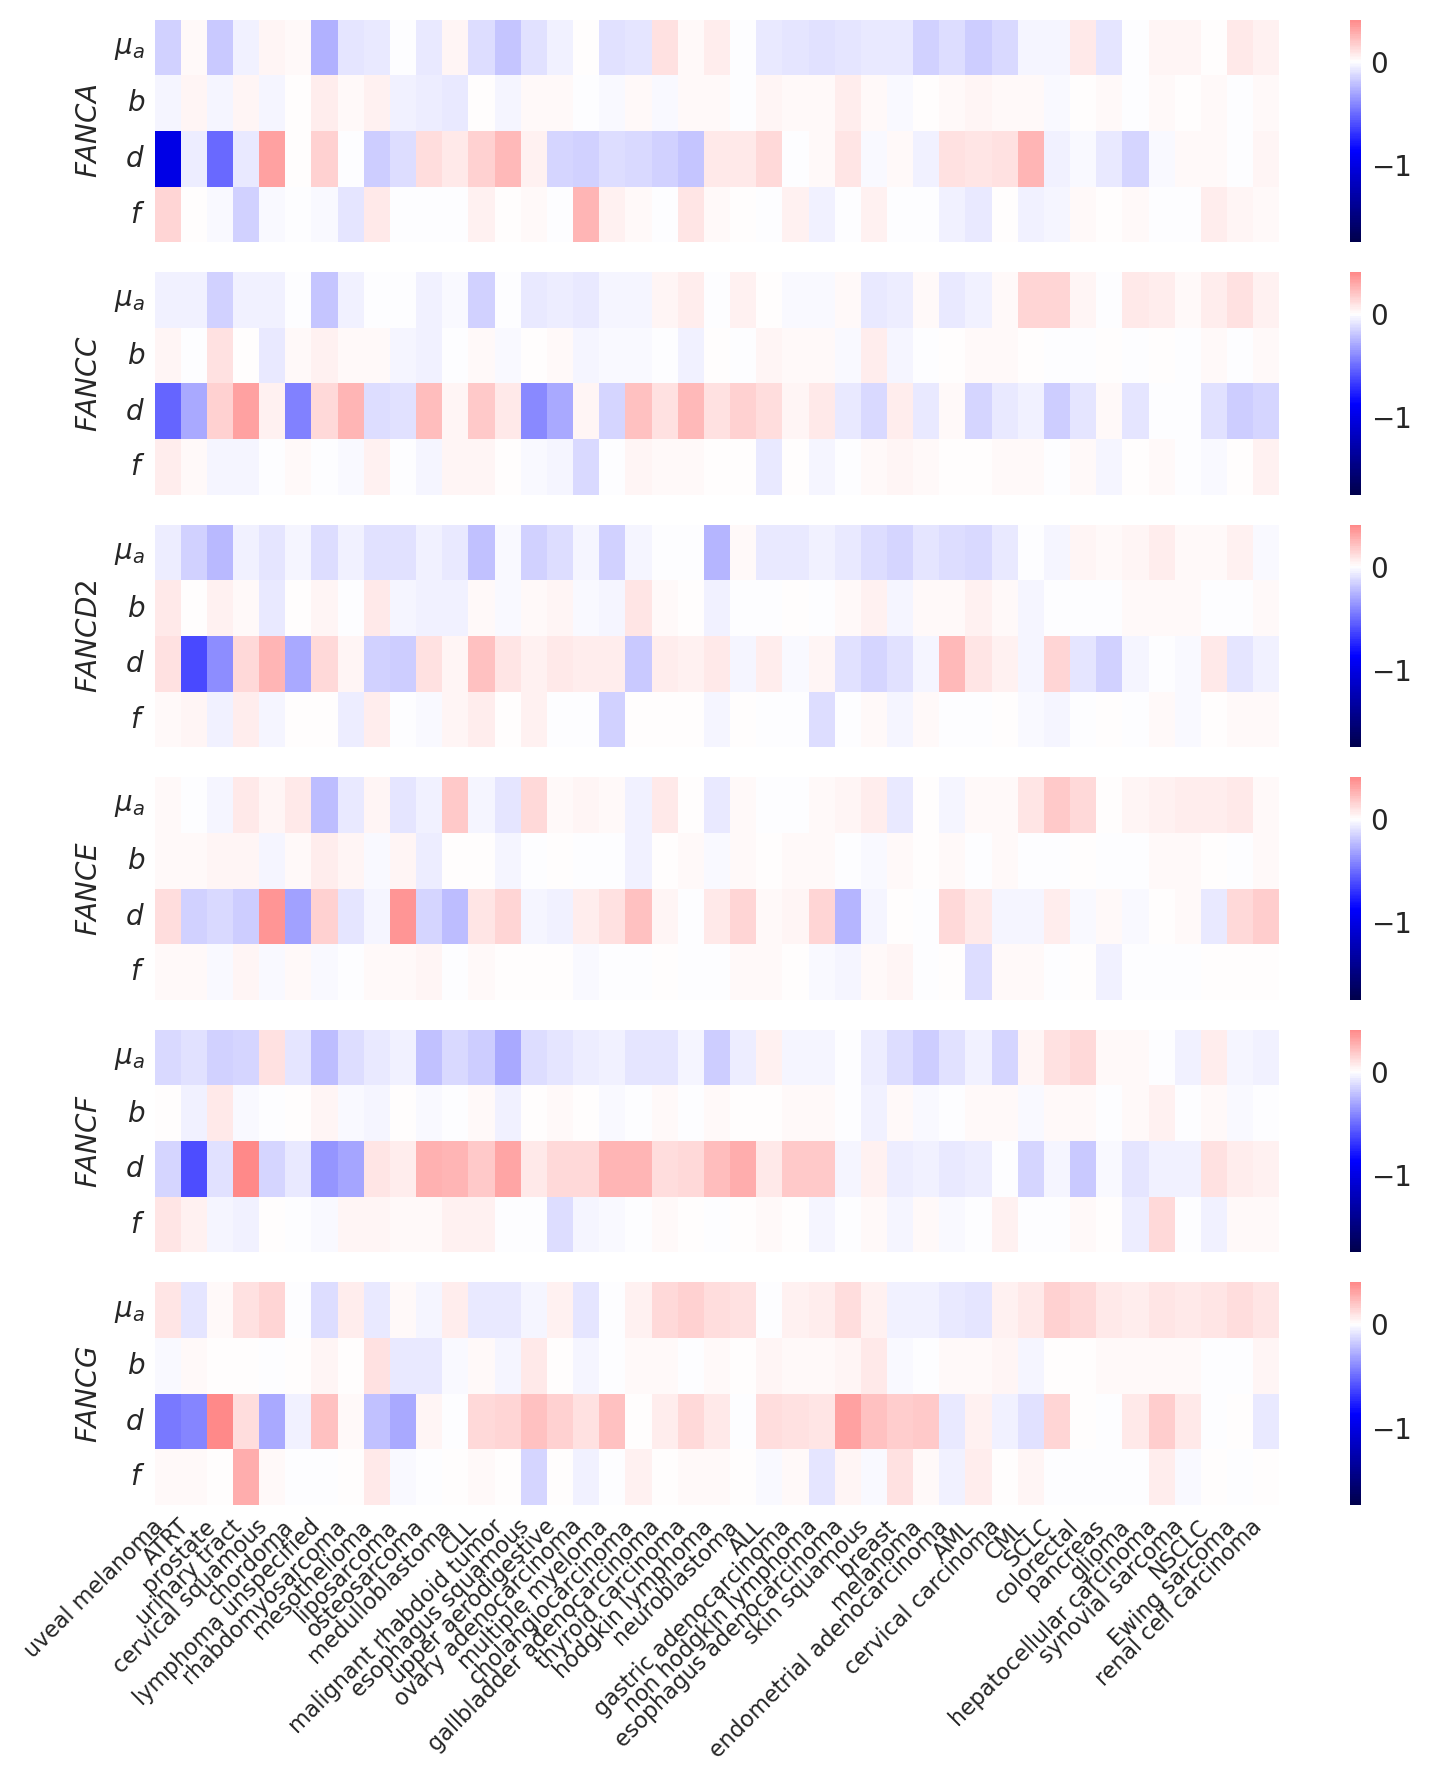

<Figure size 1000x1000 with 0 Axes>

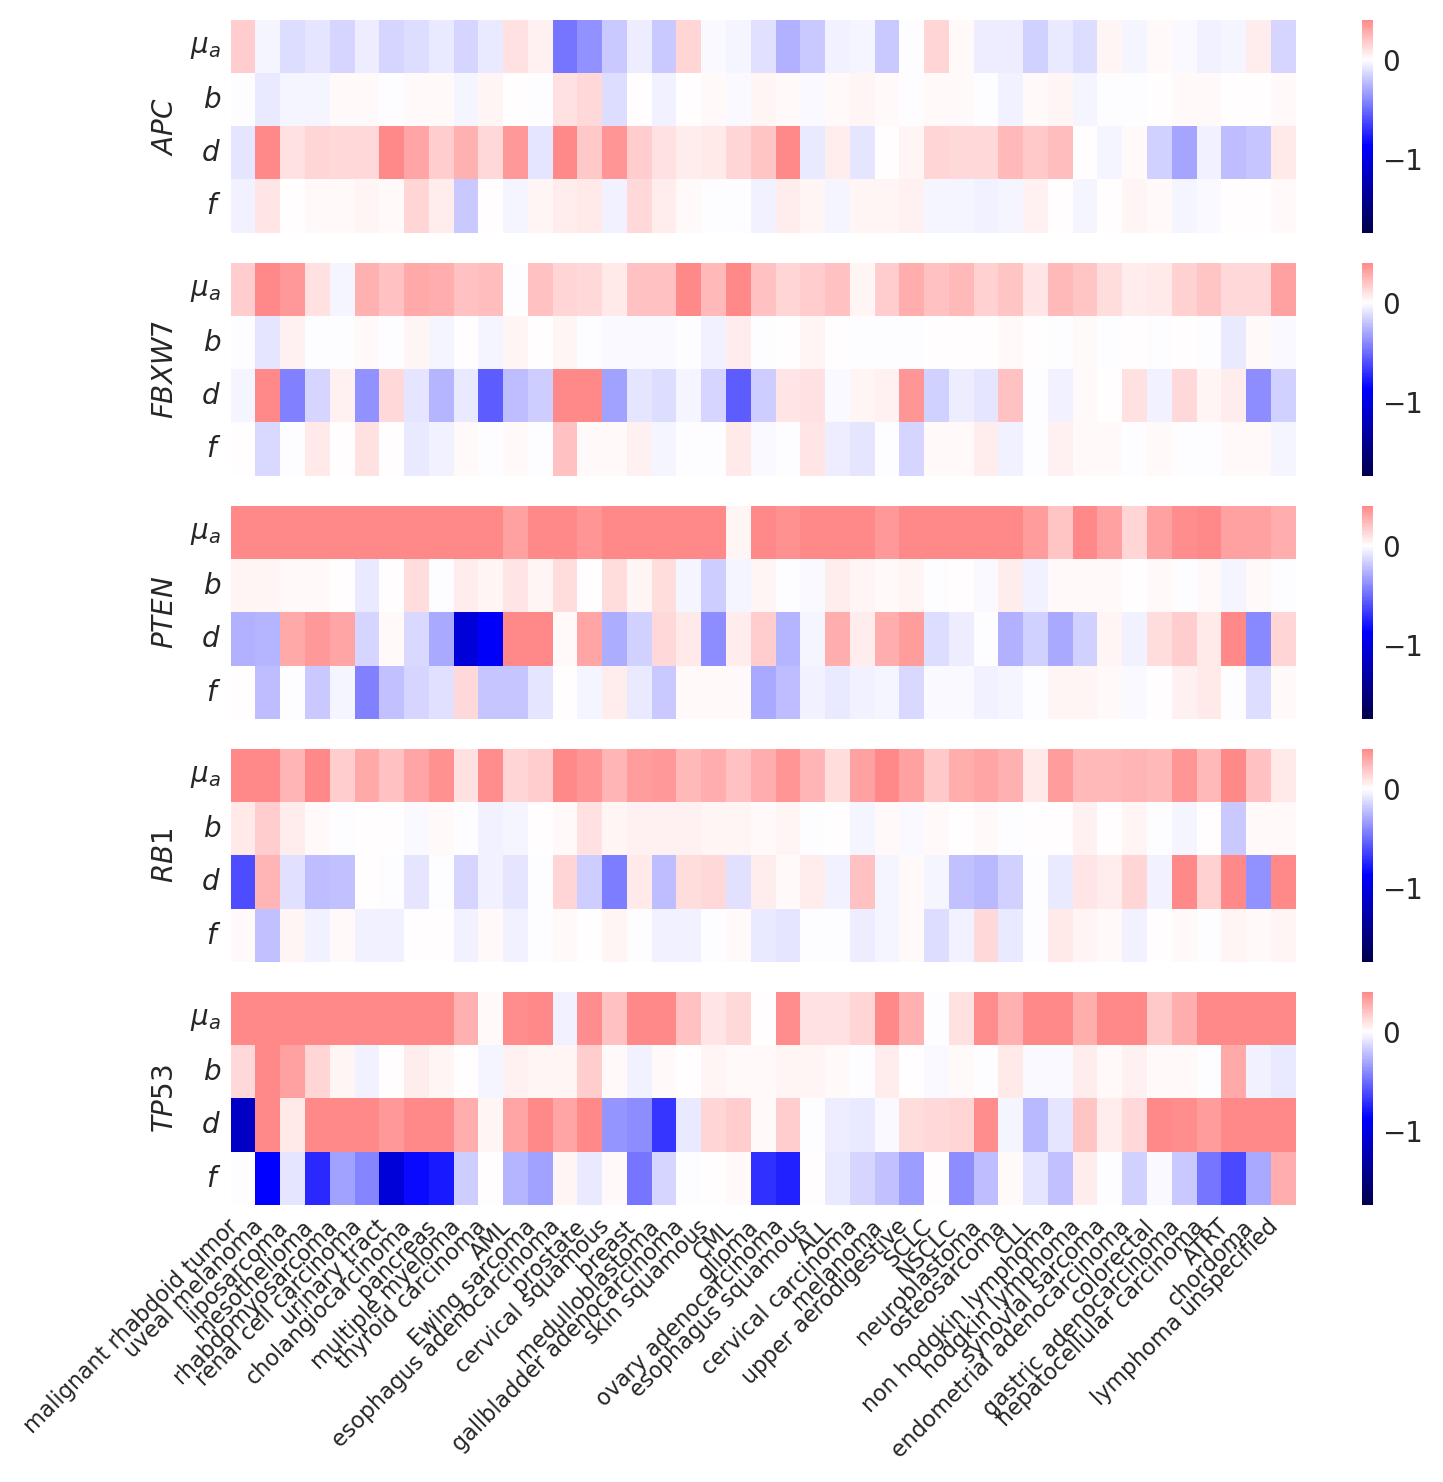

<Figure size 1000x1000 with 0 Axes>

In [16]:
all_vals = pd.concat([ras_params, raf_params])["mean"]
vmin, vmax = all_vals.min(), all_vals.max()
gene_set_characterization_heatmap(RAS_GENES, ras_params, vmin=vmin, vmax=vmax)
gene_set_characterization_heatmap(RAF_GENES, raf_params, vmin=vmin, vmax=vmax)
gene_set_characterization_heatmap(FANC_GENES, fanc_params, vmin=vmin, vmax=vmax)
gene_set_characterization_heatmap(TSGS, tsg_params, vmin=vmin, vmax=vmax);

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


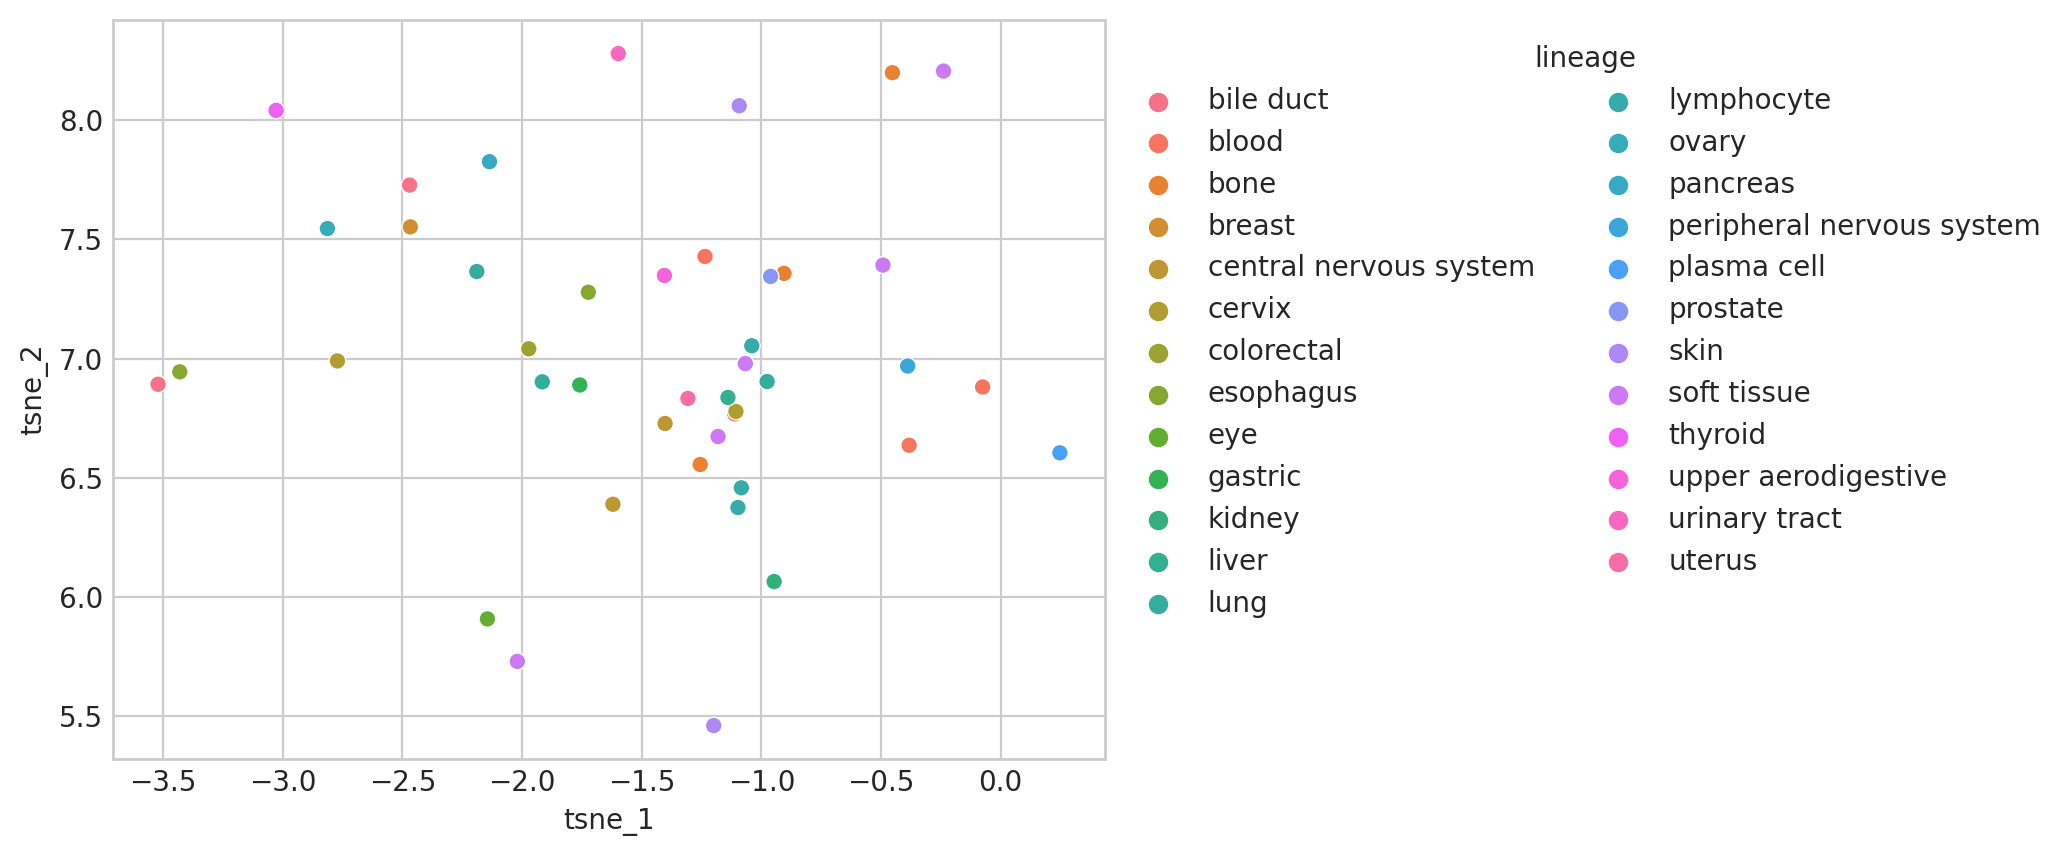

In [17]:
ras_raf_params = pd.concat([ras_params, raf_params]).reset_index(drop=True)
ras_raf_X = ras_raf_params.pivot_wider(
    "lineage_subtype", names_from="parameter", values_from="mean"
).set_index("lineage_subtype")

_tsne_res = TSNE(learning_rate="auto", init="pca").fit_transform(ras_raf_X)
tsne_res = (
    pd.DataFrame(_tsne_res, columns=[f"tsne_{i+1}" for i in range(_tsne_res.shape[1])])
    .assign(lineage_subtype=ras_raf_X.index.values)
    .assign(lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage))
)

ax = sns.scatterplot(data=tsne_res, x="tsne_1", y="tsne_2", hue="lineage")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="lineage", ncol=2)

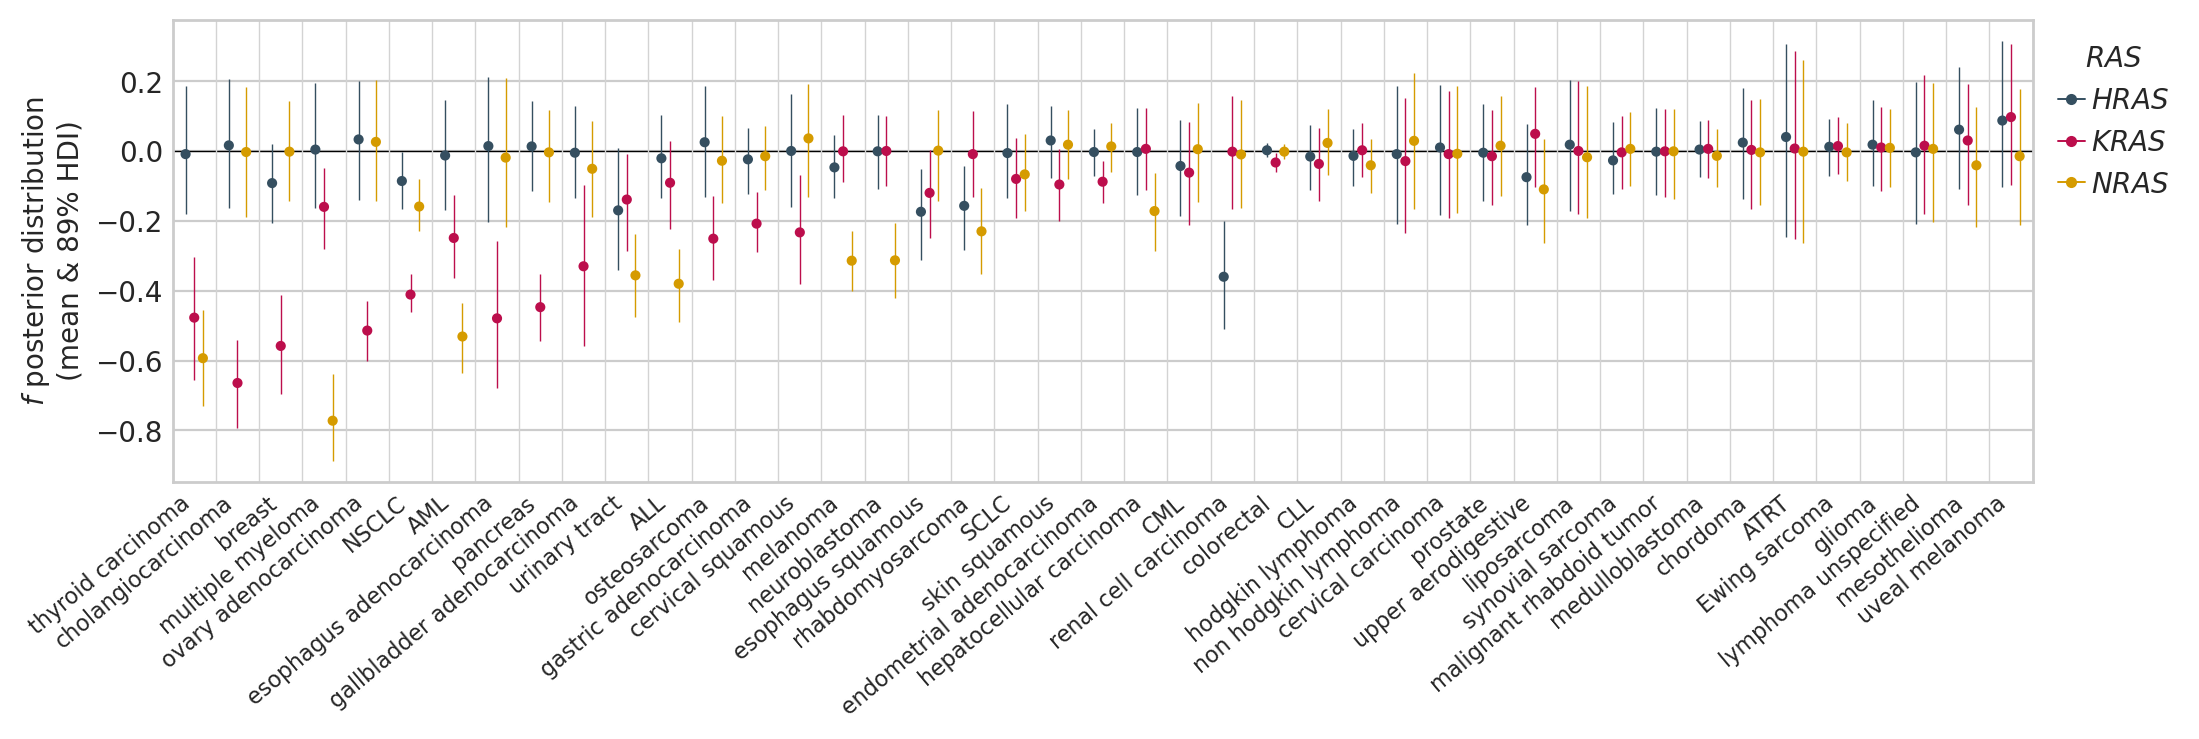

In [18]:
ras_f = (
    ras_params.copy()
    .query("var_name == 'f'")
    .reset_index(drop=True)
    .astype({"hugo_symbol": "category"})
)

ras_scores = {"KRAS": 3, "NRAS": 2, "HRAS": 1}

subline_order = (
    ras_f.assign(
        score=lambda d: d["hugo_symbol"].astype(str).map(ras_scores) ** 2 * d["mean"]
    )
    .groupby("lineage_subtype")["score"]
    .sum()
    .reset_index()
    .sort_values("score")["lineage_subtype"]
    .values.astype("str")
)
ras_f["lineage_subtype"] = pd.Categorical(
    ras_f["lineage_subtype"], categories=subline_order, ordered=True
)


_d = 0.2
dx = {"HRAS": -_d, "KRAS": 0, "NRAS": _d}
ras_pal = {"HRAS": "#354F60", "KRAS": "#BC0E4C", "NRAS": "#D59B00"}
x = ras_f["lineage_subtype"].cat.codes + np.asarray(ras_f["hugo_symbol"].map(dx).values)
colors = ras_f["hugo_symbol"].map(ras_pal)


fig, ax = plt.subplots(figsize=(12, 3))
ax.axhline(0, c="k", lw=0.5, zorder=1)
ax.vlines(
    x=x,
    ymin=ras_f["hdi_5.5%"],
    ymax=ras_f["hdi_94.5%"],
    colors=colors,
    lw=0.5,
    zorder=10,
)
ax.scatter(x=x, y=ras_f["mean"], c=colors, s=7, zorder=20)

xlbls = [extract_sublineage(s) for s in ras_f["lineage_subtype"].cat.categories]
ax.set_xticks(
    ticks=np.arange(ras_f["lineage_subtype"].nunique()),
    labels=xlbls,
    rotation=40,
    ha="right",
    fontsize=8,
)
ax.set_xlim(-0.5, ras_f["lineage_subtype"].nunique() - 0.5)

for i in range(ras_f["lineage_subtype"].nunique()):
    ax.axvline(i + 0.5, c="lightgray", lw=0.5, zorder=2)

ras_pal_italic = {f"${k}$": v for k, v in ras_pal.items()}
ax.legend(
    handles=pal_to_legend_handles(ras_pal_italic, lw=0.7, marker="o", markersize=3),
    title="$RAS$",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handlelength=1,
    handletextpad=0.2,
)
ax.grid(False, axis="x")

ax.set_ylabel("$f$ posterior distribution\n(mean & 89% HDI)")
plt.show()

In [19]:
def get_mutation_f_summaries(pm: PostDataMan, stash: bool = True) -> pd.DataFrame:
    stash_fp = STASH_DIR / f"mutation-f-summary-{pm.id}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)
    res = (
        pm.posterior_summary.copy()
        .query("var_name == 'f'")
        .reset_index(drop=True)
        .assign(lineage_subtype=pm.id)
        .pipe(extract_coords_param_names, col="parameter", names=["hugo_symbol"])
    )
    res.to_csv(stash_fp, index=False)
    return res

In [20]:
def _hdi_contains_zero(low: float, high: float) -> bool:
    return low < 0 < high


hdi_contains_zero = np.vectorize(_hdi_contains_zero)

In [21]:
f_post = (
    pd.concat([get_mutation_f_summaries(pm) for pm in postmen.as_dict().values()])
    .reset_index(drop=True)
    .assign(lineage=lambda d: d["lineage_subtype"].map(sub_to_lineage))
    .assign(zero_hdi=lambda d: hdi_contains_zero(d["hdi_5.5%"], d["hdi_94.5%"]))
)
f_post.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage_subtype,hugo_symbol,lineage,zero_hdi
0,f[A1BG],-0.004,0.117,-0.188,0.188,0.001,0.002,9718.0,2826.0,1.00,f,bile duct (cholangiocarcinoma),A1BG,bile duct,True
1,f[A1CF],-0.010,0.096,-0.162,0.143,0.001,0.002,9056.0,2534.0,1.00,f,bile duct (cholangiocarcinoma),A1CF,bile duct,True
2,f[A2M],-0.008,0.093,-0.159,0.141,0.001,0.002,10978.0,2870.0,1.01,f,bile duct (cholangiocarcinoma),A2M,bile duct,True
3,f[A2ML1],0.017,0.088,-0.126,0.155,0.001,0.002,10213.0,2477.0,1.00,f,bile duct (cholangiocarcinoma),A2ML1,bile duct,True
4,f[A3GALT2],0.075,0.100,-0.079,0.241,0.001,0.001,8710.0,2902.0,1.00,f,bile duct (cholangiocarcinoma),A3GALT2,bile duct,True


number of genes in heatmap: 3310


/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


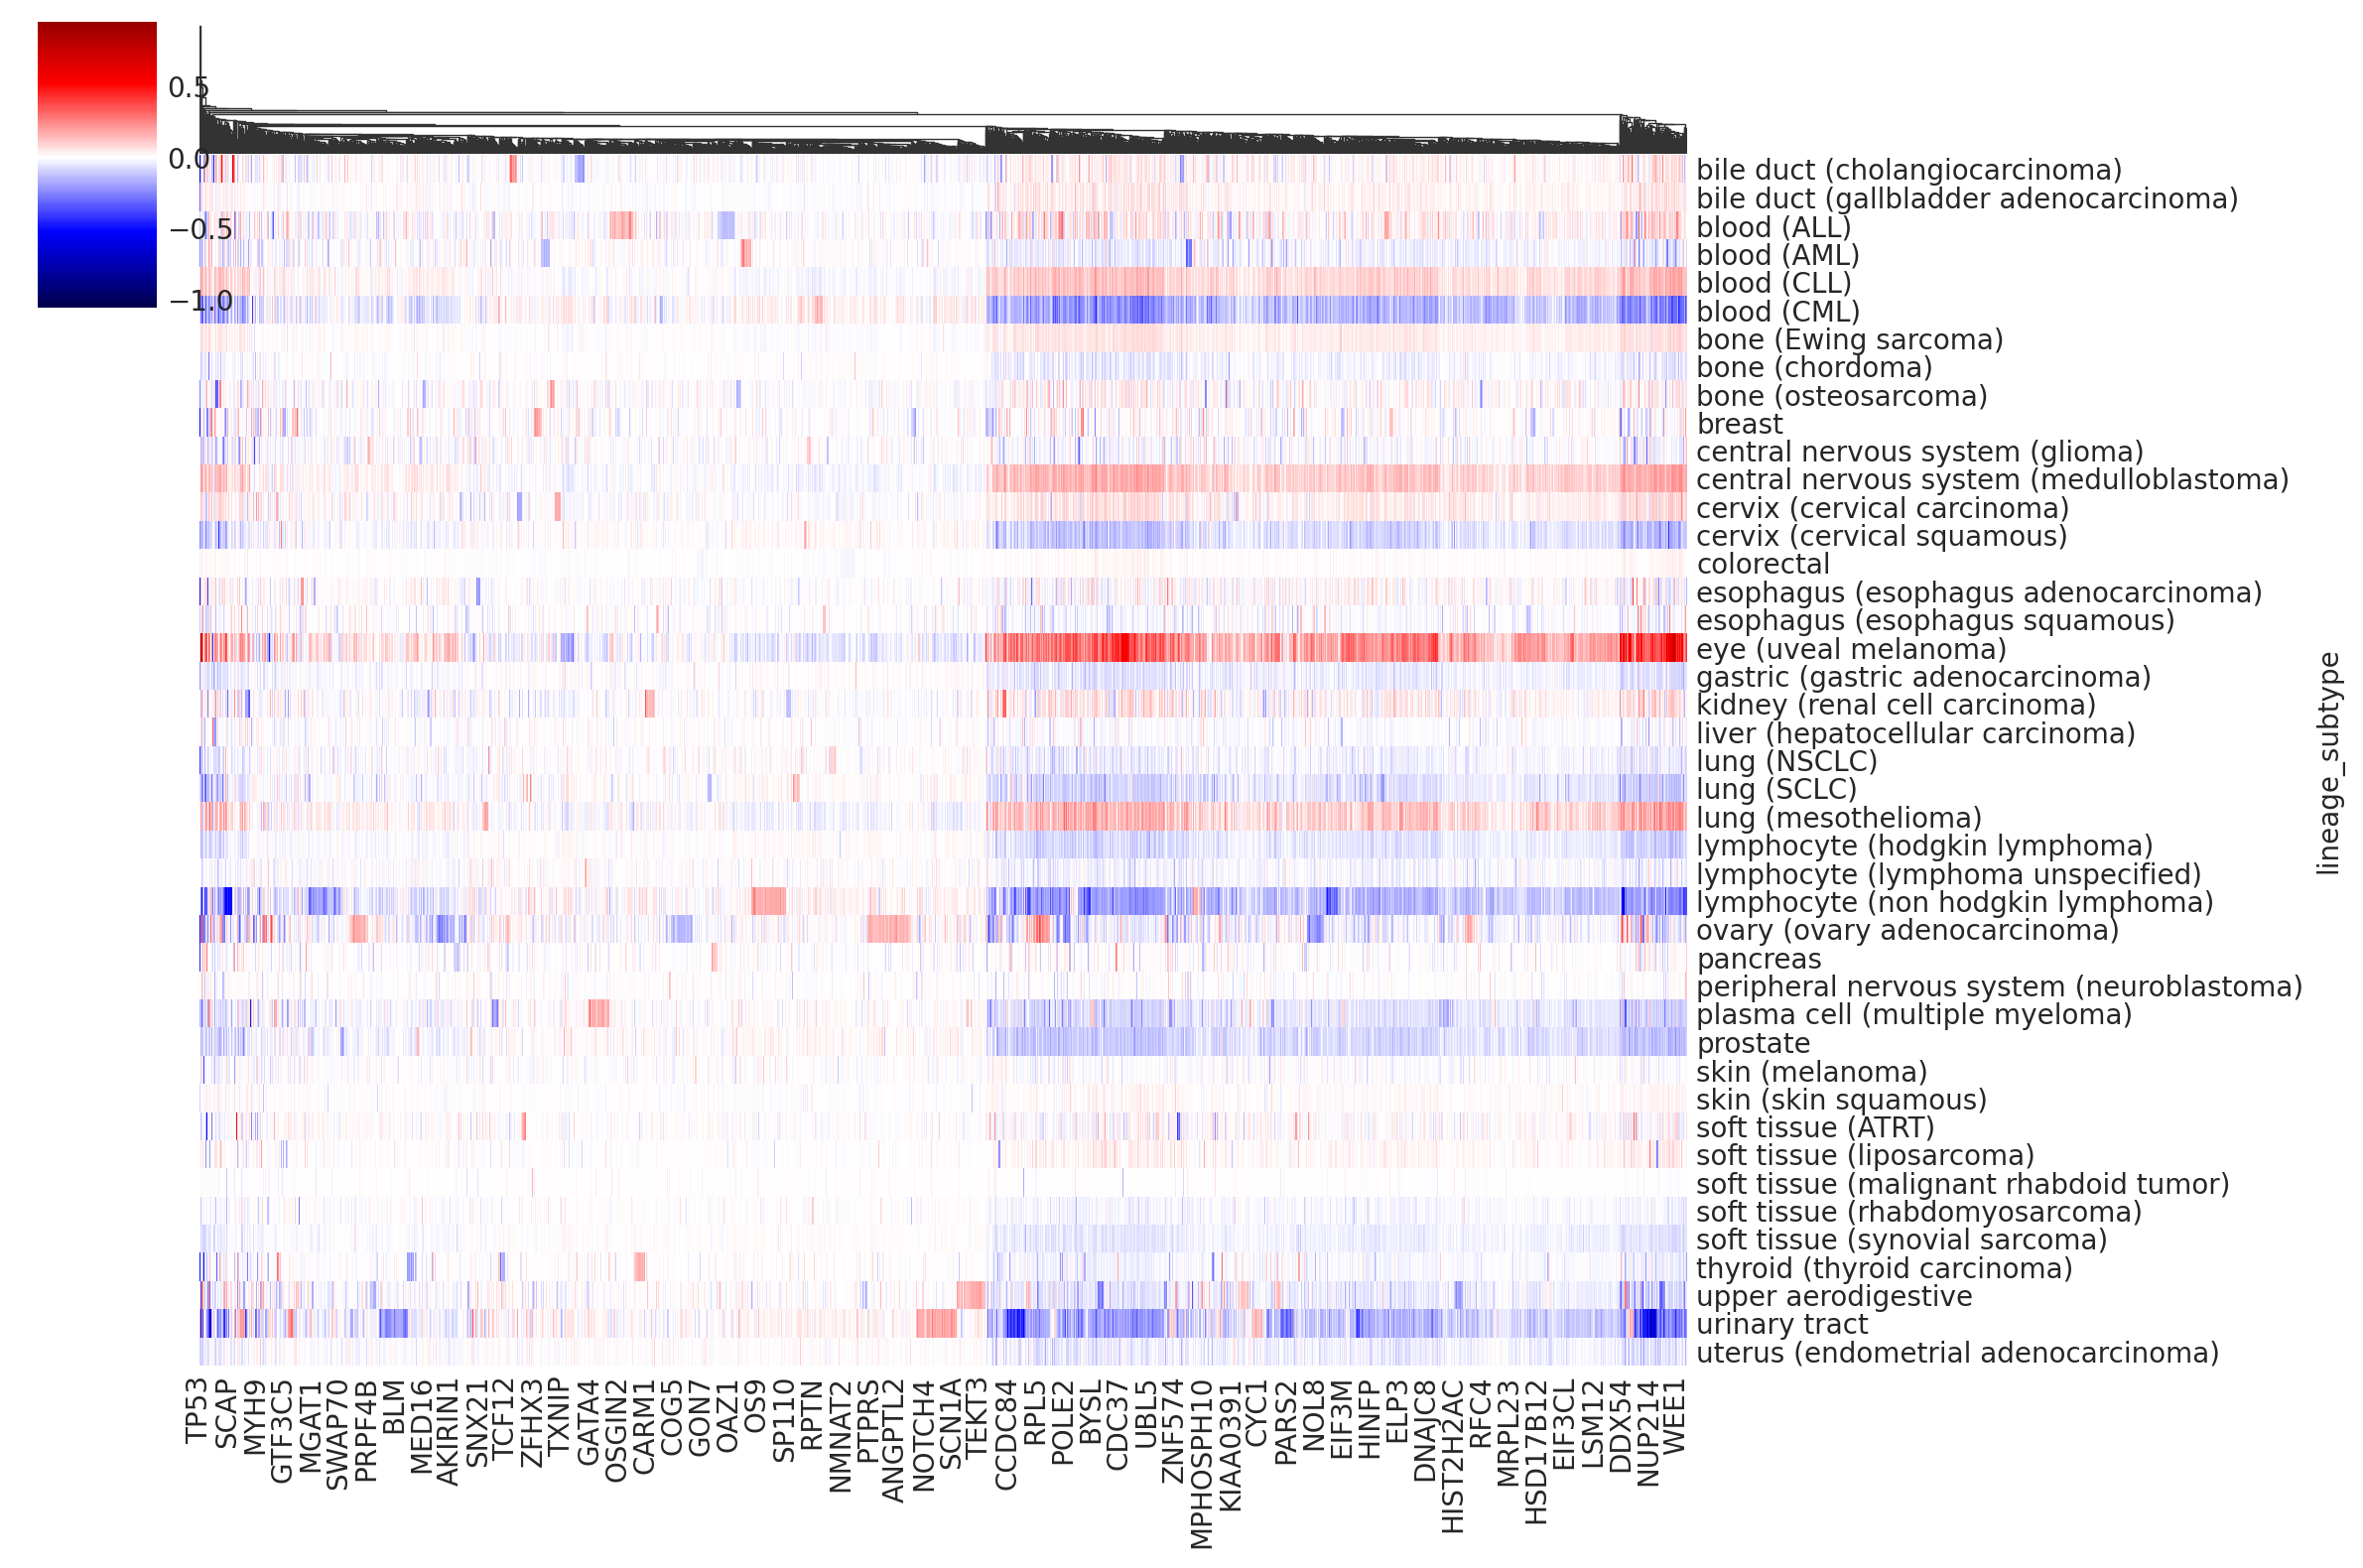

In [22]:
any_nonzero = f_post.query("not zero_hdi")["hugo_symbol"].toset()
print(f"number of genes in heatmap: {len(any_nonzero)}")
plot_df = (
    f_post.filter_column_isin("hugo_symbol", any_nonzero)
    .pivot_wider("lineage_subtype", names_from="hugo_symbol", values_from="mean")
    .set_index("lineage_subtype")
)
sns.clustermap(
    plot_df,
    figsize=(12, 8),
    dendrogram_ratio=(0.1, 0.1),
    row_cluster=False,
    cmap="seismic",
    center=0,
    yticklabels=1,
)

number of hits in blood lineage: 569


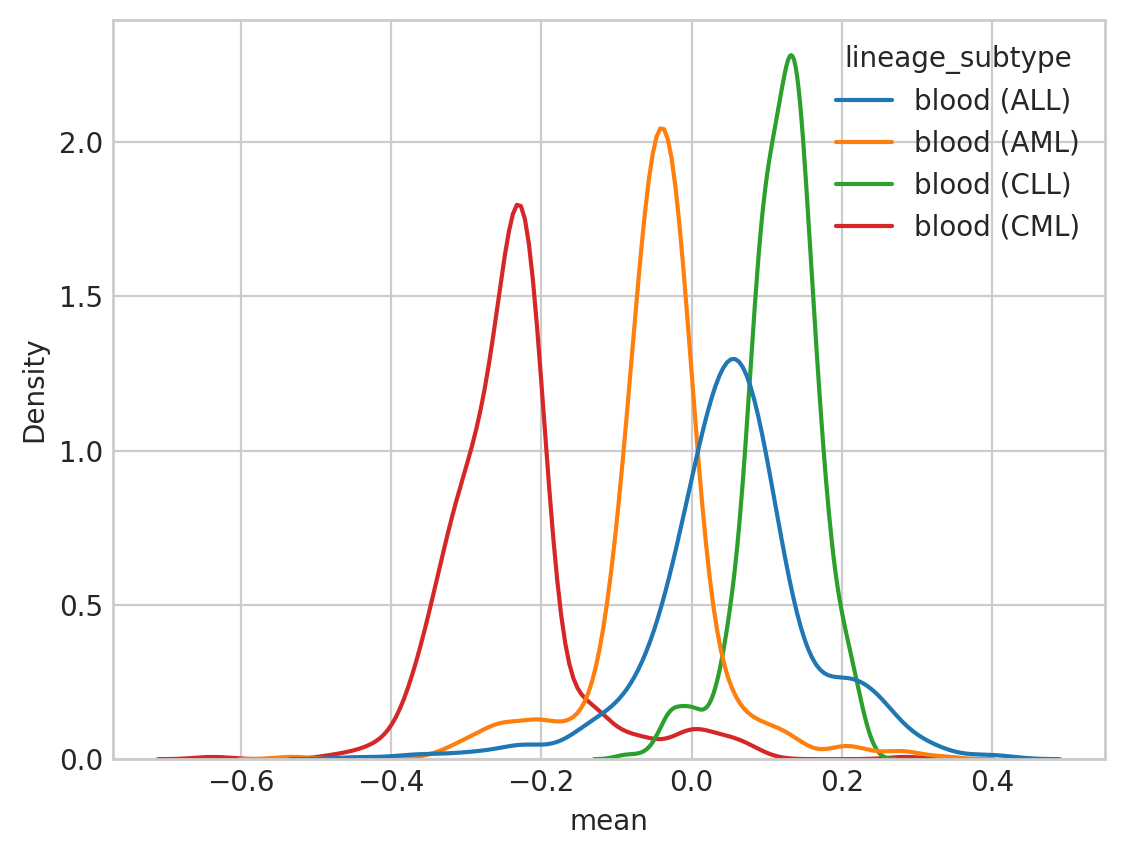

In [23]:
blood_f_hits = (
    f_post.query("lineage == 'blood'")
    .query("not zero_hdi")
    .query("mean < -0.2 or mean > 0.2")["hugo_symbol"]
    .toset()
)
print(f"number of hits in blood lineage: {len(blood_f_hits)}")
f_post_blood = f_post.query("lineage == 'blood'").filter_column_isin(
    "hugo_symbol", blood_f_hits
)

sns.kdeplot(data=f_post_blood, x="mean", hue="lineage_subtype");

In [24]:
def get_blood_hits_data(
    pm: PostDataMan, hits: Collection[str], stash: bool = True
) -> pd.DataFrame:
    hits_hash = str_hash("_".join(hits))
    stash_fp = STASH_DIR / f"blood-hits_{pm.id}_{hits_hash}.csv"
    if stash and stash_fp.exists():
        return pd.read_csv(stash_fp)

    res = (
        dd.read_csv(
            pm.data_file,
            low_memory=False,
            dtype={"age": "float64", "primary_or_metastasis": object},
        )
        .query("screen == 'broad'")
        .query("hugo_symbol in @hits", local_dict={"hits": hits})
        .compute()
        .reset_index(drop=True)
    )
    res.to_csv(stash_fp, index=False)
    return res


blood_f_hits_data = pd.concat(
    [
        get_blood_hits_data(pm, blood_f_hits)
        for pm in postmen.posteriors
        if "blood" in pm.id
    ]
)
blood_f_hits_data.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage_subtype,primary_or_metastasis,is_male,age,lineage
0,CATCGACGATGATAGCGAGG,697-311CAS9_RepA_p6_batch3,-0.839641,3,chr21_44113827_-,PWP2,broad,True,21,44113827,...,NaN,NaN,NaN,False,0.991341,ALL,primary,True,12.0,blood_(ALL)
1,CATGGCGTCGCCCTTCAGCG,697-311CAS9_RepA_p6_batch3,-0.216331,3,chr16_740969_-,CIAO3,broad,True,16,740969,...,NaN,NaN,NaN,False,1.083653,ALL,primary,True,12.0,blood_(ALL)
2,CGCCAAAATGACGAACACAA,697-311CAS9_RepA_p6_batch3,-0.383453,3,chr13_27253786_+,RPL21,broad,True,13,27253786,...,NaN,NaN,NaN,False,1.018267,ALL,primary,True,12.0,blood_(ALL)
3,CTCGGACAGCACCCTCCCCG,697-311CAS9_RepA_p6_batch3,-0.754283,3,chr4_190173807_+,DUX4,broad,True,4,190173807,...,NaN,NaN,NaN,False,1.400450,ALL,primary,True,12.0,blood_(ALL)
4,GACGTGGTAGATCTTGTCAG,697-311CAS9_RepA_p6_batch3,-0.167526,3,chr16_733414_+,CIAO3,broad,True,16,733414,...,NaN,NaN,NaN,False,1.083653,ALL,primary,True,12.0,blood_(ALL)


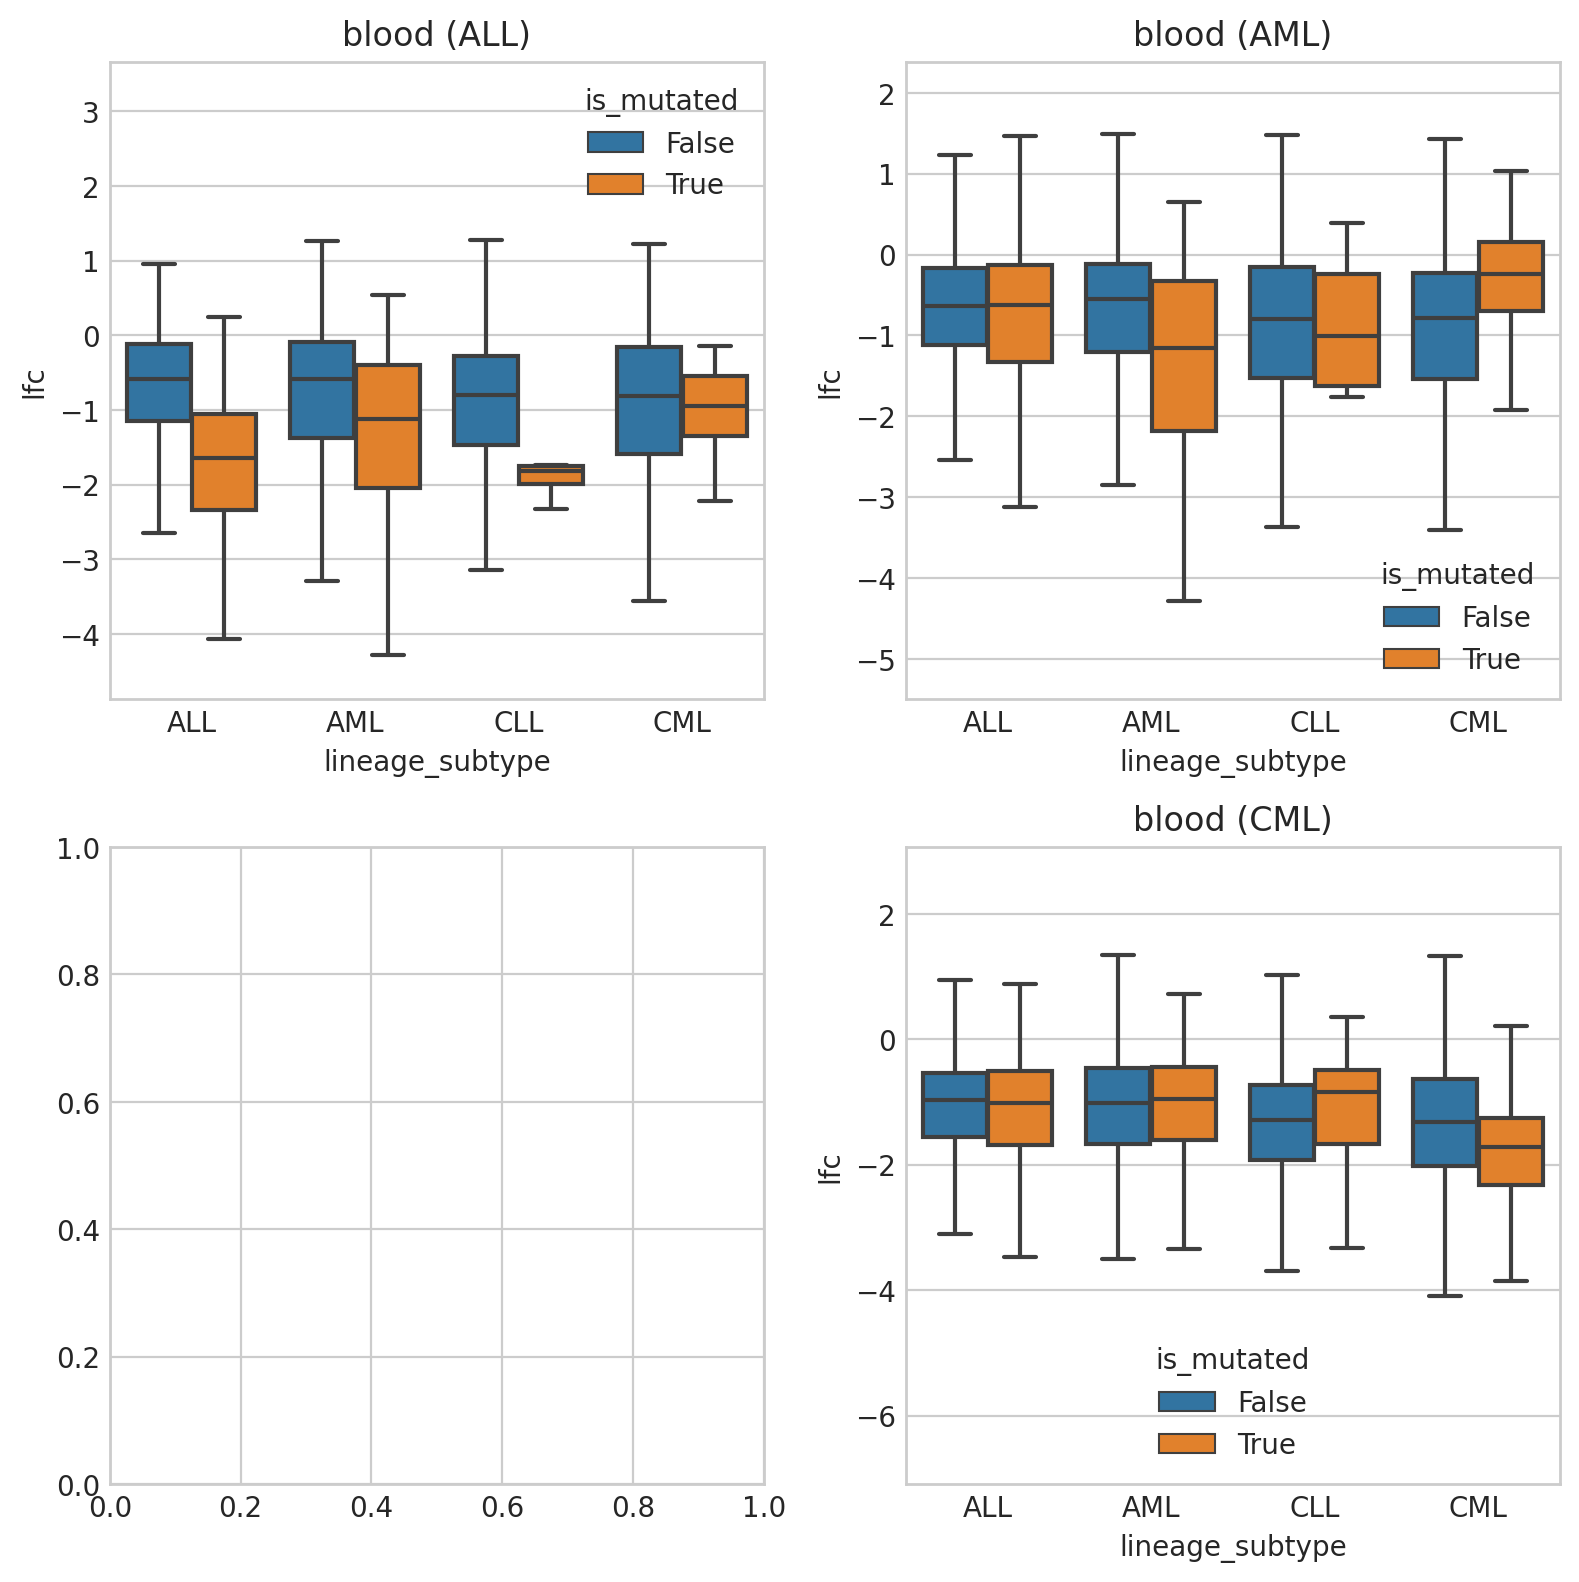

In [25]:
blood_types = [b.replace("_", " ") for b in blood_f_hits_data["lineage"].unique()]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for ax, blood in zip(axes.flatten(), blood_types):
    dn_hits = f_post_blood.query(f"lineage_subtype == '{blood}' and mean < -0.2")[
        "hugo_symbol"
    ].toset()
    if len(dn_hits) == 0:
        continue
    plot_df = blood_f_hits_data.filter_column_isin("hugo_symbol", dn_hits)
    sns.boxplot(
        data=plot_df, x="lineage_subtype", y="lfc", hue="is_mutated", ax=ax, fliersize=0
    )
    ax.set_title(blood)

fig.tight_layout()
plt.show()

Compare adeno vs. squamous

In [26]:
squamous = {a for a in postmen.keys if "squamous" in a}
squamous = squamous.union({"lung (SCLC)"})
adeno = {a for a in postmen.keys if "adeno" in a}
adeno = adeno.union({"colorectal", "pancreas", "prostate", "lung (NSCLC)"})
assert len(squamous.intersection(adeno)) == 0
print(squamous)
print(adeno)

{'esophagus (esophagus squamous)', 'lung (SCLC)', 'skin (skin squamous)', 'cervix (cervical squamous)'}
{'bile duct (gallbladder adenocarcinoma)', 'gastric (gastric adenocarcinoma)', 'lung (NSCLC)', 'prostate', 'ovary (ovary adenocarcinoma)', 'colorectal', 'pancreas', 'uterus (endometrial adenocarcinoma)', 'esophagus (esophagus adenocarcinoma)'}


In [27]:
f_post_adeno_squa = (
    f_post.copy()
    .filter_column_isin("lineage_subtype", adeno.union(squamous))
    .reset_index(drop=True)
)

adeno_squa_nonzero = (
    f_post_adeno_squa.query("zero_hdi")
    .query("mean < -0.1 or 0.1 < mean")["hugo_symbol"]
    .toset()
)
print(f"number of `f` hits: {len(adeno_squa_nonzero)}")
f_post_adeno_squa.head()

number of `f` hits: 1471


,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_name,lineage_subtype,hugo_symbol,lineage,zero_hdi
0,f[A1BG],0.005,0.081,-0.120,0.138,0.001,0.001,7004.0,2309.0,1.0,f,bile duct (gallbladder adenocarcinoma),A1BG,bile duct,True
1,f[A1CF],-0.003,0.081,-0.137,0.119,0.001,0.001,8303.0,2949.0,1.0,f,bile duct (gallbladder adenocarcinoma),A1CF,bile duct,True
2,f[A2M],-0.021,0.080,-0.155,0.096,0.001,0.001,9361.0,2452.0,1.0,f,bile duct (gallbladder adenocarcinoma),A2M,bile duct,True
3,f[A2ML1],-0.016,0.078,-0.141,0.110,0.001,0.001,8927.0,2840.0,1.0,f,bile duct (gallbladder adenocarcinoma),A2ML1,bile duct,True
4,f[A3GALT2],-0.016,0.084,-0.144,0.123,0.001,0.002,9804.0,2808.0,1.0,f,bile duct (gallbladder adenocarcinoma),A3GALT2,bile duct,True


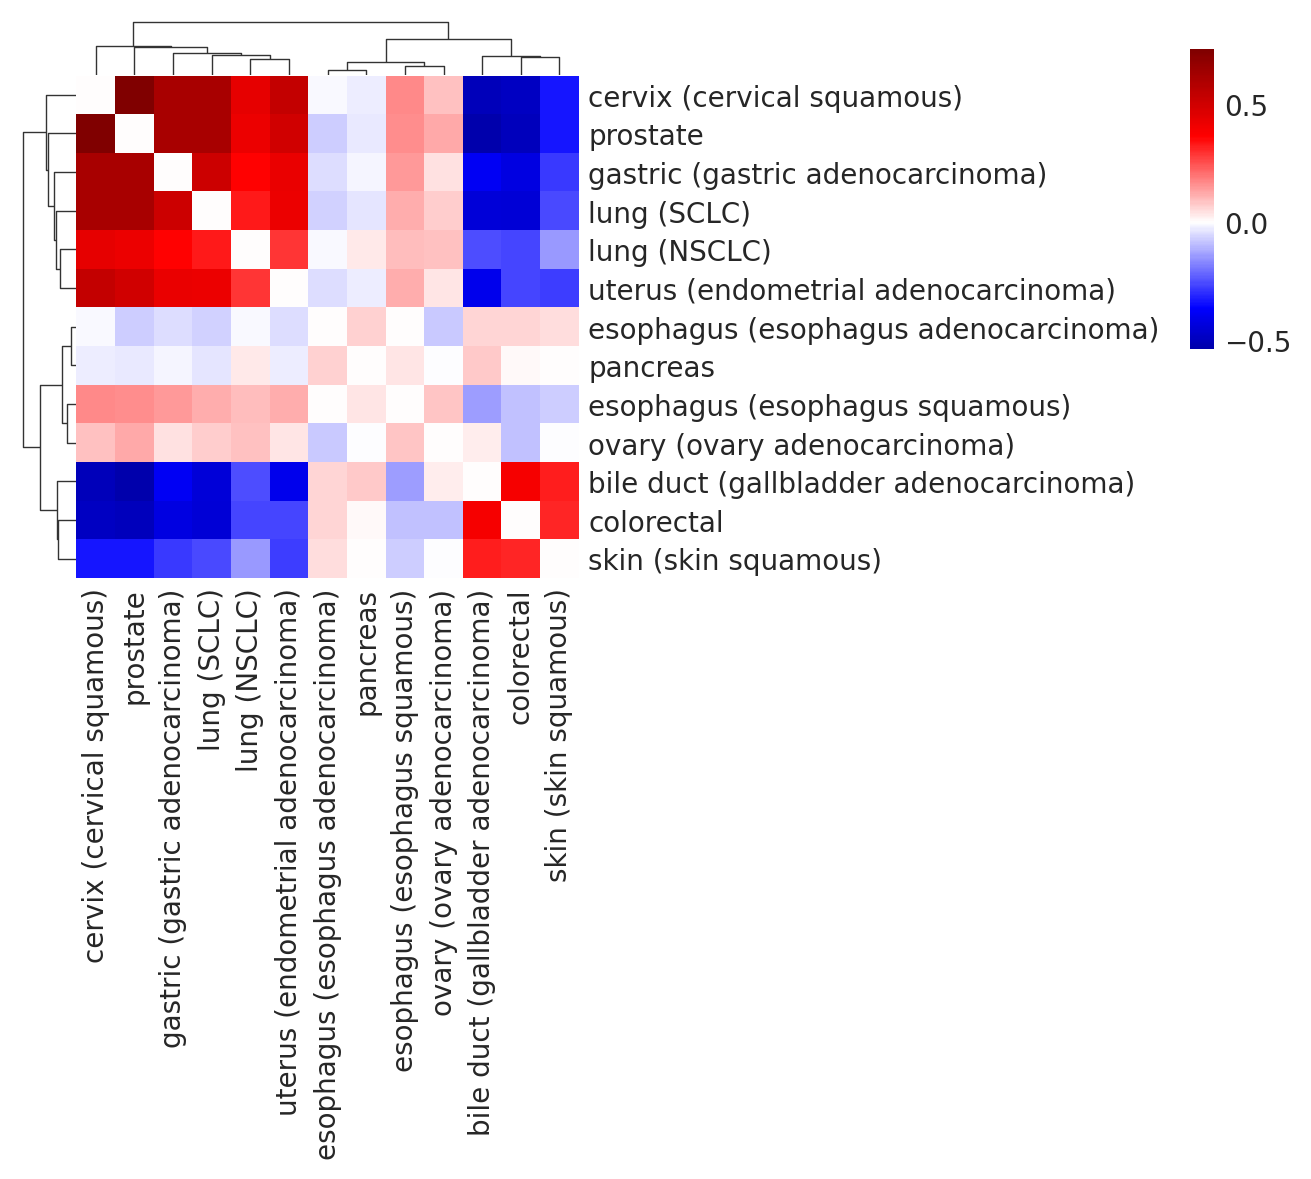

In [28]:
adeno_squa_corr = (
    f_post_adeno_squa.filter_column_isin("hugo_symbol", adeno_squa_nonzero)
    .pivot_wider("hugo_symbol", names_from="lineage_subtype", values_from="mean")
    .set_index("hugo_symbol")
    .corr()
)

mask = np.zeros_like(adeno_squa_corr.values, dtype=bool)
np.fill_diagonal(mask, True)

adeno_squa_corr[mask] = 0
sns.clustermap(
    adeno_squa_corr,
    figsize=(6, 6),
    dendrogram_ratio=(0.1, 0.1),
    cmap="seismic",
    center=0,
    cbar_pos=(1, 0.7, 0.02, 0.25),
)
plt.show()

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.99 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-09-18

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 3.10.0-1160.76.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: figures

seaborn   : 0.11.2
numpy     : 1.23.3
matplotlib: 3.5.3
dask      : 2022.9.0
pandas    : 1.4.4

